# SARIMA 

In [1]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from concurrent.futures import ProcessPoolExecutor
from loky import get_reusable_executor
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd

from itertools import product
from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## Wetter Daten

In [2]:
# Daten
data = pd.read_csv('../data/processed_weather_data_6h.csv')
data.head()

,Date_Time,p_(mbar),T_(degC),Tpot_(K),Tdew_(degC),rh_(%),VPmax_(mbar),VPact_(mbar),VPdef_(mbar),sh_(g/kg),...,Wy,max_Wx,max_Wy,day_of_month,day_of_year,month,week_of_year,year,p_(mbar)_lag_1,T_(degC)_lag_1
0,2009-01-01 00:00:00,996.882000,-8.884000,264.514000,-9.776000,93.180000,3.118000,2.906000,0.212000,1.814000,...,0.003740,-0.569765,-0.019364,0.032258,0.002740,0.083333,0.018868,0.0,0.000000,0.000
1,2009-01-01 06:00:00,999.340000,-8.175000,265.033333,-9.240000,91.983333,3.301667,3.035000,0.266667,1.890000,...,-0.692450,0.319851,-1.227428,0.032258,0.002740,0.083333,0.018868,0.0,996.882000,-8.884
2,2009-01-01 12:00:00,1000.021667,-5.860000,267.300000,-7.308333,89.416667,3.941667,3.526667,0.416667,2.195000,...,0.443973,-1.641755,0.725355,0.032258,0.002740,0.083333,0.018868,0.0,999.340000,-8.175
3,2009-01-01 18:00:00,1000.093333,-4.838333,268.315000,-6.250000,89.750000,4.260000,3.825000,0.435000,2.381667,...,-0.128681,-0.818595,-0.206013,0.032258,0.002740,0.083333,0.018868,0.0,1000.021667,-5.860
4,2009-01-02 00:00:00,998.828333,-4.543333,268.705000,-5.260000,94.683333,4.356667,4.126667,0.233333,2.571667,...,-0.002832,-0.588270,0.049298,0.064516,0.005479,0.083333,0.018868,0.0,0.000000,0.000


In [3]:
# Datengröße
data.shape

(11688, 23)

In [4]:
# Datenauswahl,SARIMA nimmt nur eine Eingabe + Exog-Variable und gibt nur eine Ausgabe aus.
# Hier T (degC) für Temperatur
in_str= "T_(degC)"
exog_str = "day_of_month"
temp_data = data[["Date_Time", in_str, exog_str]]
temp_data.shape

(11688, 3)

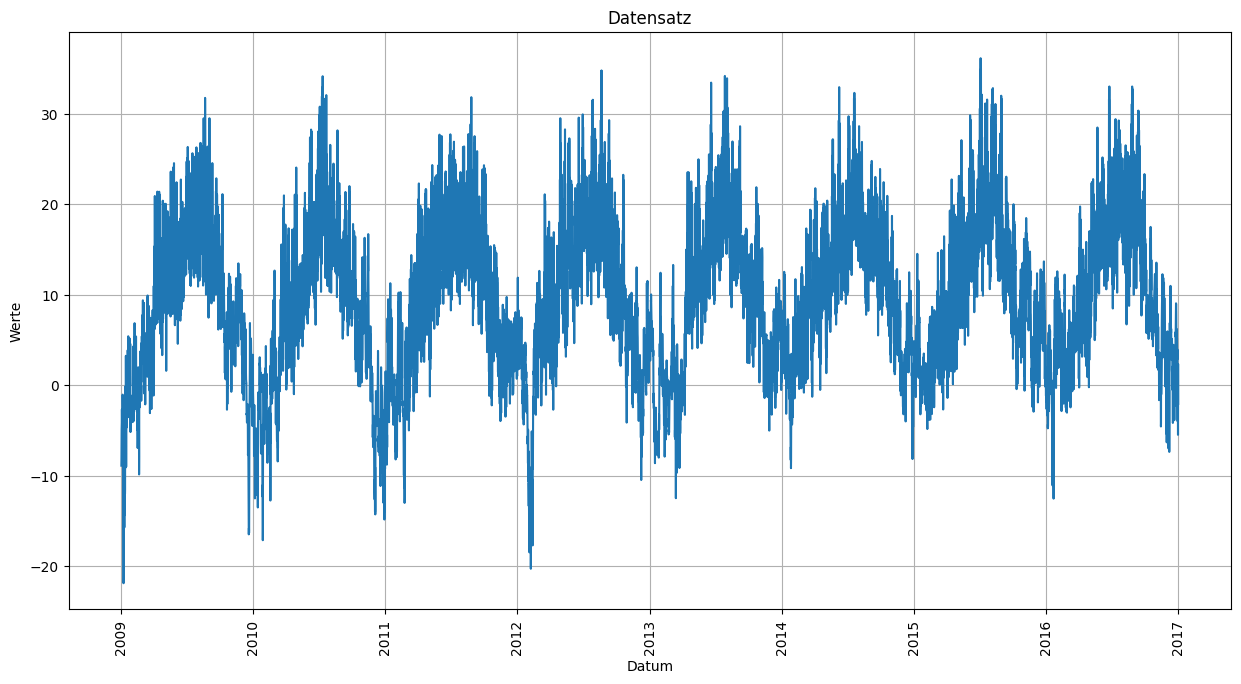

In [5]:
# Datensatz visualisieren und Stationarität bestätigen
plt.figure(figsize=[15, 7.5]); 
date = pd.to_datetime(temp_data["Date_Time"], format="%Y-%m-%d %H:%M:%S")
plt.plot(date, temp_data[in_str])
plt.title('Datensatz')
plt.ylabel('Werte')
plt.xlabel('Datum')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

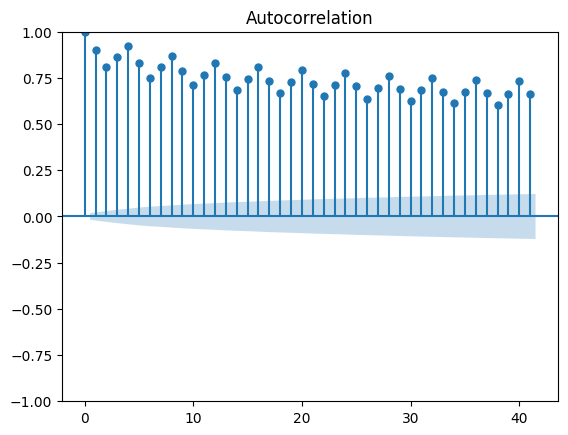

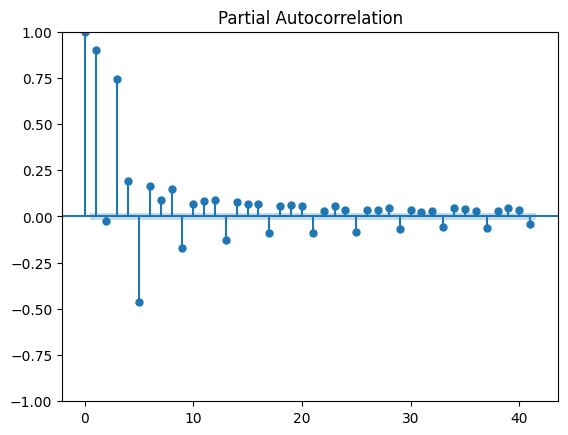

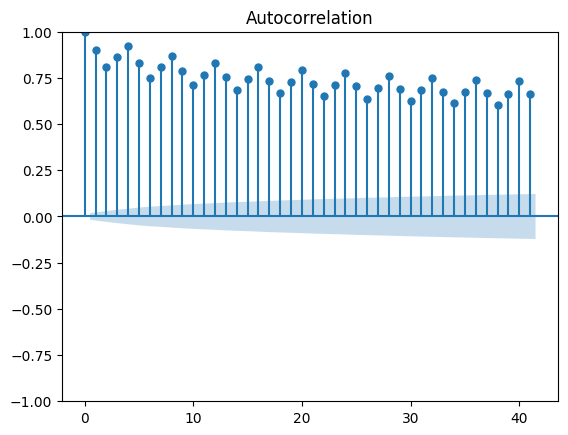

In [6]:
#Das Model benötigt folgende 3 Werte (d,D,s): 
#   - d - Integrationsordnung: Differenzierung bis daten stationär sind.
#   - D - saisonale Integrationsordnung: Differenzierung der Saisonalität.
#   - s - Länge der Saison: Eine Seasonalität kann sich durch die Periodizität der Welle im Acf bestimmen. 

plot_pacf(temp_data[in_str])
plot_acf(temp_data[in_str])

In [7]:
# Es ist eine Saisonalität von 4 zu erkennen.
# Augmented Dickey-Fuller test: Präsenz von Einheitswurzeln im Datensatz

ad_fuller_result = adfuller(temp_data[in_str])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -5.317958576181977
p-value: 5.025613935048312e-06


In [8]:
#ADF-Statistik: Der Wert von -5.317958576181977 liegt wahrscheinlich nicht unterhalb des kritischen Werts für einen bestimmten Signifikanzniveau. In der Regel ist ein negativer ADF-Wert ein gutes Zeichen für Stationarität.
#p-Wert: Der p-Wert 5.025613935048312e-06 bedeutet, dass es sehr wahrscheinlich ist, dass die Zeitreihe keine Einheitswurzel enthält und es kann die Nullhypothese abgelehnt werden. 
# => Es wird in diesem Notebook eine Integrationsordnung von d=1 und eine saisonale Integrationsordnung von D=1 angewendet, für den Vergleich mit einer Anwendung ohne Integration in Notebook: "Eval_SARIMA_weather_6h_d0_D0_s4_exog.ipynb"

#An Hand des ADfuller-test und der PAC/AC-Funktion ist eine saisonale Differenzierung von 4 plausible.
# Der negative Wert bei Lag 3 könnte darauf hindeuten, dass eine nicht-saisonale Differenzierung von 1 möglicherweise ausreicht, aber nicht nötig ist.

In [9]:
# Integrationsordnung = d: Erster Differenzierungsschritt
data_d = temp_data.copy()
data_d[in_str] = data_d[in_str].diff(1)
data_d = data_d.drop([1], axis=0).reset_index(drop=True) # Nur falls die ersten Werte NaN sind. Die erste Differenzierung könnte in vielen Fällen zu NaN-Werten führen, da der vorherige Wert nicht vorhanden ist.
data_d.dropna(subset=[in_str], inplace=True)

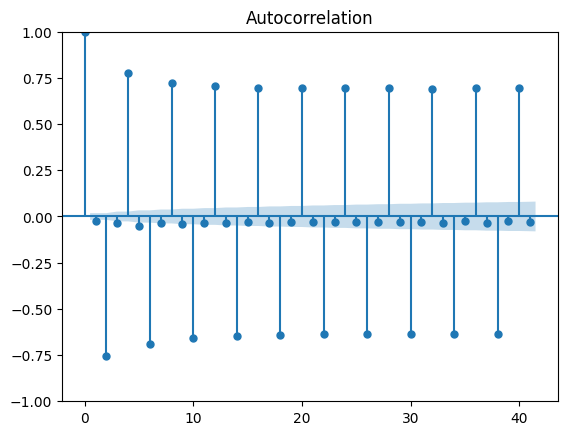

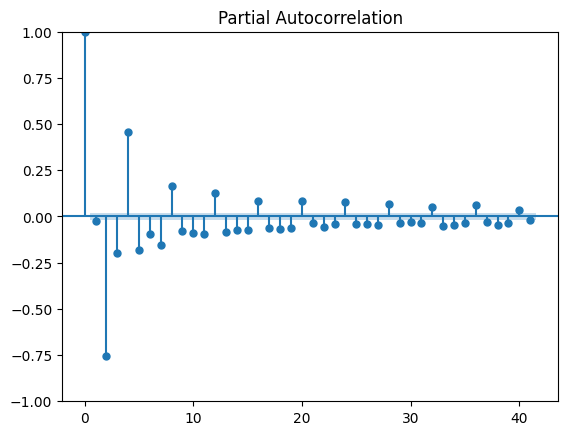

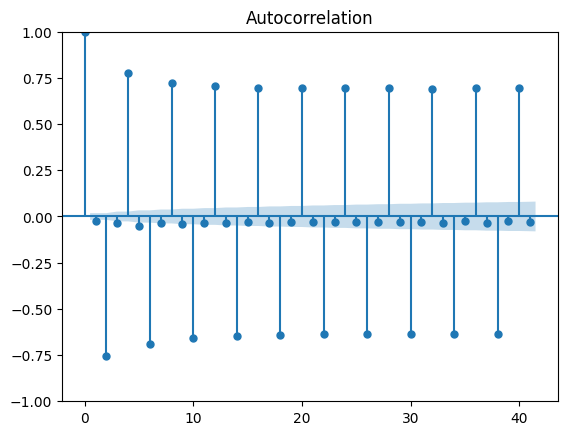

In [10]:
plot_pacf(data_d[in_str])
plot_acf(data_d[in_str])

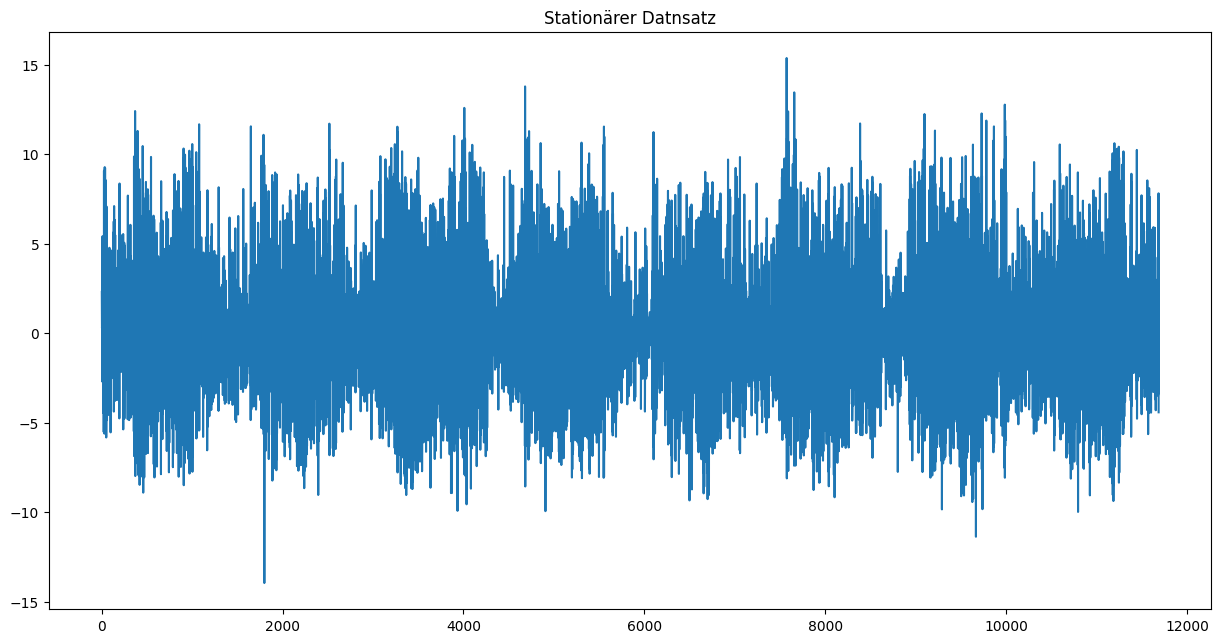

In [11]:
plt.figure(figsize=[15, 7.5]); 
plt.plot(data_d[in_str])
plt.title("Stationärer Datnsatz")
plt.show()

In [12]:
ad_fuller_result = adfuller(data_d[in_str])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -22.749850595080602
p-value: 0.0


In [13]:
#Diese Werte deuten darauf hin, dass die Nullhypothese der Nicht-Stationarität nun sicher abgelehnt werden kann, da der p-Wert kleiner ist als das übliche Signifikanzniveau. Die ADF-Statistik ist ausreichend negativ, was zusätzlich darauf hinweist, dass die Zeitreihe jetzt als stationär betrachtet werden kann.
# Somit ist d = 1

# Nun muss noch die saisonalen Integrationsordnung (D) berechnet werden. 
# Welcher durch ablesen im ACF bei 2 liegen sollte und beim PACF bei 4.
# Es wird in diesem Notebook mit einer Differnzierung von 4 gearbeitet.


In [14]:
# Saisonale Integrationsordnung = D: Erster Differenzierungsschritt
data_D = data_d.copy()
data_D[in_str] = data_D[in_str].diff(4)
data_D = data_D.drop([1, 2, 3, 4], axis=0).reset_index(drop=True)
data_D.dropna(subset=[in_str], inplace=True)


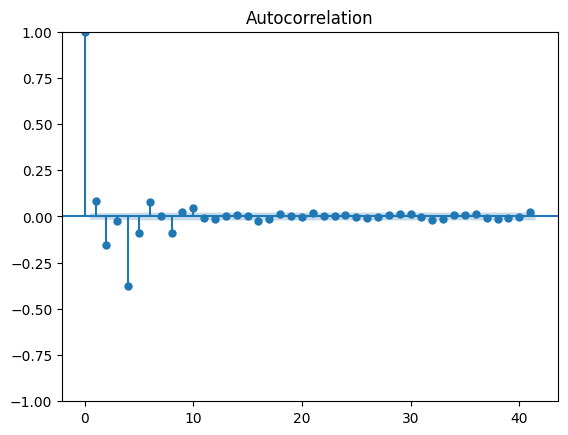

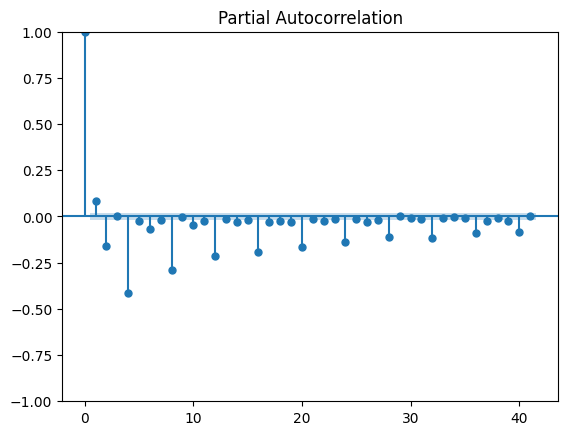

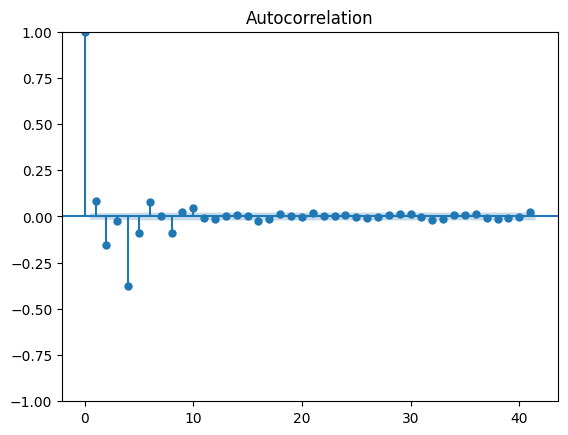

In [15]:
plot_pacf(data_D[in_str])
plot_acf(data_D[in_str])

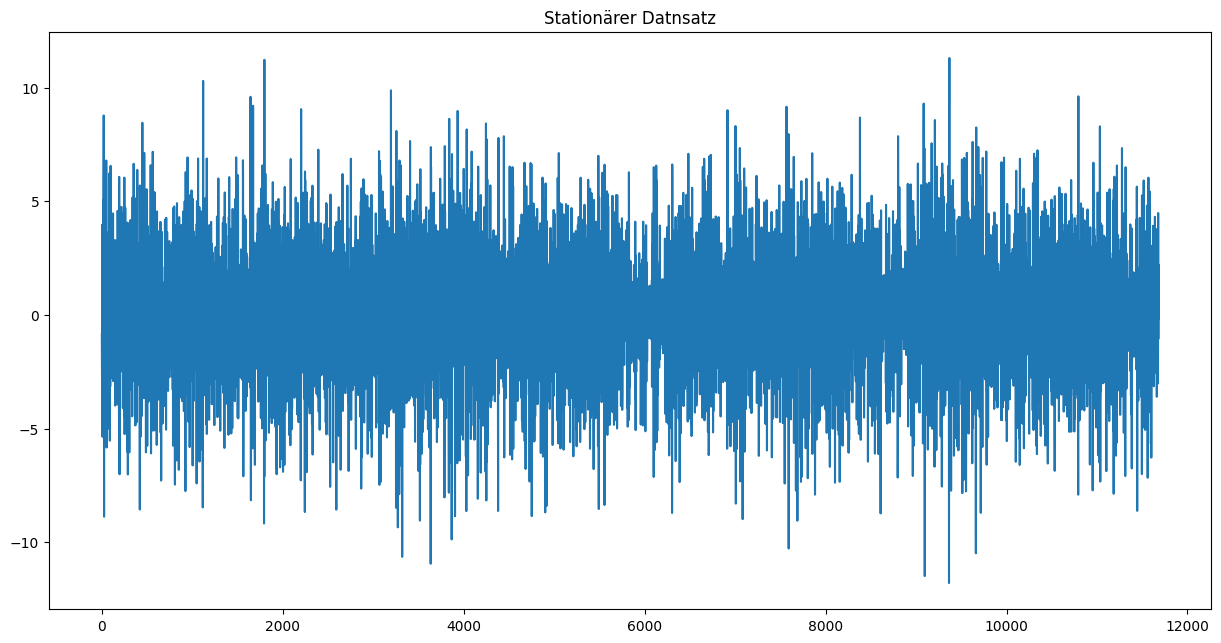

In [16]:
plt.figure(figsize=[15, 7.5]); 
plt.plot(data_D[in_str])
plt.title("Stationärer Datnsatz")
plt.show()

In [17]:
ad_fuller_result = adfuller(data_D[in_str])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -32.46755666974187
p-value: 0.0


In [18]:
def train_val_test_split(data, train_ratio=0.7, val_ratio=0.15):
    train_size = int(len(data) * train_ratio)
    val_size = int(len(data) * val_ratio)
    train_data = data[:train_size]
    val_data = data[train_size:train_size+val_size]
    test_data = data[train_size+val_size:]
    return train_data, val_data, test_data


def train_sarimax(train_data, order, seasonal_order):
    return SARIMAX(train_data, order=order, seasonal_order=seasonal_order).fit(dis=-1)

def evaluate_model(model, test_data):
    predictions = model.forecast(steps=len(test_data))
    mae = mean_absolute_error(test_data, predictions)
    return mae

In [19]:
# Nun wird der differnenzierte Datensatz für die weiteren Vorgänge verwendet
diff_data = data_D # Nur um die Übersicht zu behalten

In [20]:
train_data, val_data, test_data = train_val_test_split(diff_data)

In [21]:
def optimize_SARIMA(parameters_list, d, D, s, train, exog, exog_future, val_data=None):
    """
        Rückgabe des DataFrame mit Parametern, entsprechenden AIC (relative Qualität statistischer Modelle) und SSE (Differenzen zwischen beobachteten und vorhergesagten Werten).#
        Desto kleiner der AIC und SSE-Wert, desto besser das Model.
        
        
        
        parameters_list - Liste mit Tupeln (p, q, P, Q)
        d - Integrationsordnung
        D - saisonale Integrationsordnung
        s - Länge der Saison
        train - die Trainingsdaten
        exog - die exogene Variable
        exog_future - die exogenen Validierungsdaten
        val_data - die Validierungsdaten
    """
    results = []

    train_df = train.to_frame('train_column_name')
    exog_df = exog.to_frame('exog_column_name')   

    if not train_df.index.equals(exog_df.index):
        # Synchronisierung der Indizes
        combined = train_df.join(exog_df, how='inner')  # Dies führt zu einem DataFrame, bei dem nur übereinstimmende Indizes behalten werden

        # Trennung der synchronisierten Daten zurück in endogen und exogen
        train_synced = combined[train_df.columns]
        exog_synced = combined[exog_df.columns]
    else:
        # Wenn die Indizes bereits übereinstimmen
        train_synced = train_df
        exog_synced = exog_df

    for param in tqdm_notebook(parameters_list):
            
       
        try: 
            model = SARIMAX(endog=train_synced, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], s), exog=exog_synced).fit(disp=-1)
            aic = model.aic

            # Berechnung des MAE, wenn val_data bereitgestellt wird
            if val_data is not None:
                predictions = model.get_prediction(start=len(train_synced), end=len(train_synced)+len(val_data)-1, exog=exog_future)
                prediction_summary = predictions.summary_frame()
                mae = mean_absolute_error(val_data, prediction_summary['mean'])
                results.append([param, aic, mae])
            else:
                results.append([param, aic])

        except:
            continue
            
    result_df = pd.DataFrame(results)
    print(result_df)
    if val_data is not None:
        result_df.columns = ['(p,q)x(P,Q)', 'AIC', 'MAE']
    else:
        result_df.columns = ['(p,q)x(P,Q)', 'AIC']

    # Sortieren nach AIC (aufsteigend)
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [22]:
# Sowohl die saisonalen als auch die nicht-saisonalen Integrationsparameter sind jeweils 1 , und die Länge der Saison beträgt 4.
p = range(0, 4, 1)
d = 1
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 1
Q = range(0, 4, 1)
s = 4

parameters = product(p, q, P, Q)
parameters_list = list(parameters)
print(len(parameters_list))

256


In [28]:
result_df = optimize_SARIMA(parameters_list, d, D, s, train_data[in_str],train_data[exog_str], val_data[exog_str], val_data[in_str])
result_df

  0%|          | 0/256 [00:00<?, ?it/s]

                0             1            2
0    (0, 0, 0, 0)  51004.207287  1631.166756
1    (0, 0, 0, 1)  42906.375205     4.839127
2    (0, 0, 0, 2)  40508.136536     1.971589
3    (0, 0, 0, 3)  40009.398189     1.917608
4    (0, 0, 1, 0)  47427.029107   559.340528
..            ...           ...          ...
248  (3, 3, 2, 3)  34002.748807     1.843079
249  (3, 3, 3, 0)  37012.898774     1.968925
250  (3, 3, 3, 1)  34489.083445     1.842522
251  (3, 3, 3, 2)  34767.599432     1.844501
252  (3, 3, 3, 3)  34016.862008     1.842752

[253 rows x 3 columns]


,"(p,q)x(P,Q)",AIC,MAE
0,"(1, 2, 1, 2)",16.000000,138.634928
1,"(0, 2, 1, 2)",4214.714193,31607.781050
2,"(3, 3, 1, 3)",33796.550080,1.844236
3,"(3, 3, 0, 2)",33830.691681,1.843111
4,"(2, 3, 0, 2)",33860.076262,1.842580
...,...,...,...
248,"(0, 0, 1, 0)",47427.029107,559.340528
249,"(3, 0, 0, 0)",48360.526516,1085.452062
250,"(2, 0, 0, 0)",48633.989208,899.342367
251,"(1, 0, 0, 0)",49625.997898,1189.014407


In [29]:
result_df.sort_values(by='MAE', ascending=True).reset_index(drop=True)

,"(p,q)x(P,Q)",AIC,MAE
0,"(1, 3, 3, 2)",35444.108691,1.841410
1,"(3, 3, 1, 1)",36120.054895,1.841589
2,"(1, 3, 3, 1)",35280.788590,1.841678
3,"(2, 2, 3, 1)",35299.999093,1.841771
4,"(1, 2, 0, 2)",35178.917732,1.841799
...,...,...,...
248,"(2, 0, 0, 0)",48633.989208,899.342367
249,"(3, 0, 0, 0)",48360.526516,1085.452062
250,"(1, 0, 0, 0)",49625.997898,1189.014407
251,"(0, 0, 0, 0)",51004.207287,1631.166756


In [30]:
# Best model ist ARIMA 3,3,1,3) AIC=36120
# Das SARIMAX ist eine erweiterung des SARIMA'-s. Diese lässt zusätzliche Variablen von außen zu. zB könnte diese die Tageszeiten beinhalten, welche Einfluss auf die Wetterbedingungen haben könnte.
# order=(p,d,q) => p=3, d=1, q=3
# seasonal_order=(P,D,Q,s) => P=1, D=1, Q=3, s=4
best_model = SARIMAX(diff_data[in_str], exog=diff_data[exog_str], order=(0, 1, 1), seasonal_order=(2, 1, 3, 4)).fit(disp=-1, enforce_stationarity=False, enforce_invertibility=False)

print(best_model.summary())

                                         SARIMAX Results                                         
Dep. Variable:                                  T_(degC)   No. Observations:                11682
Model:             SARIMAX(0, 1, 1)x(2, 1, [1, 2, 3], 4)   Log Likelihood              -24759.766
Date:                                   Mon, 19 Feb 2024   AIC                          49535.532
Time:                                           14:34:12   BIC                          49594.455
Sample:                                                0   HQIC                         49555.324
                                                 - 11682                                         
Covariance Type:                                     opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
day_of_month  6.515e-05      0.022      0.003      0.9

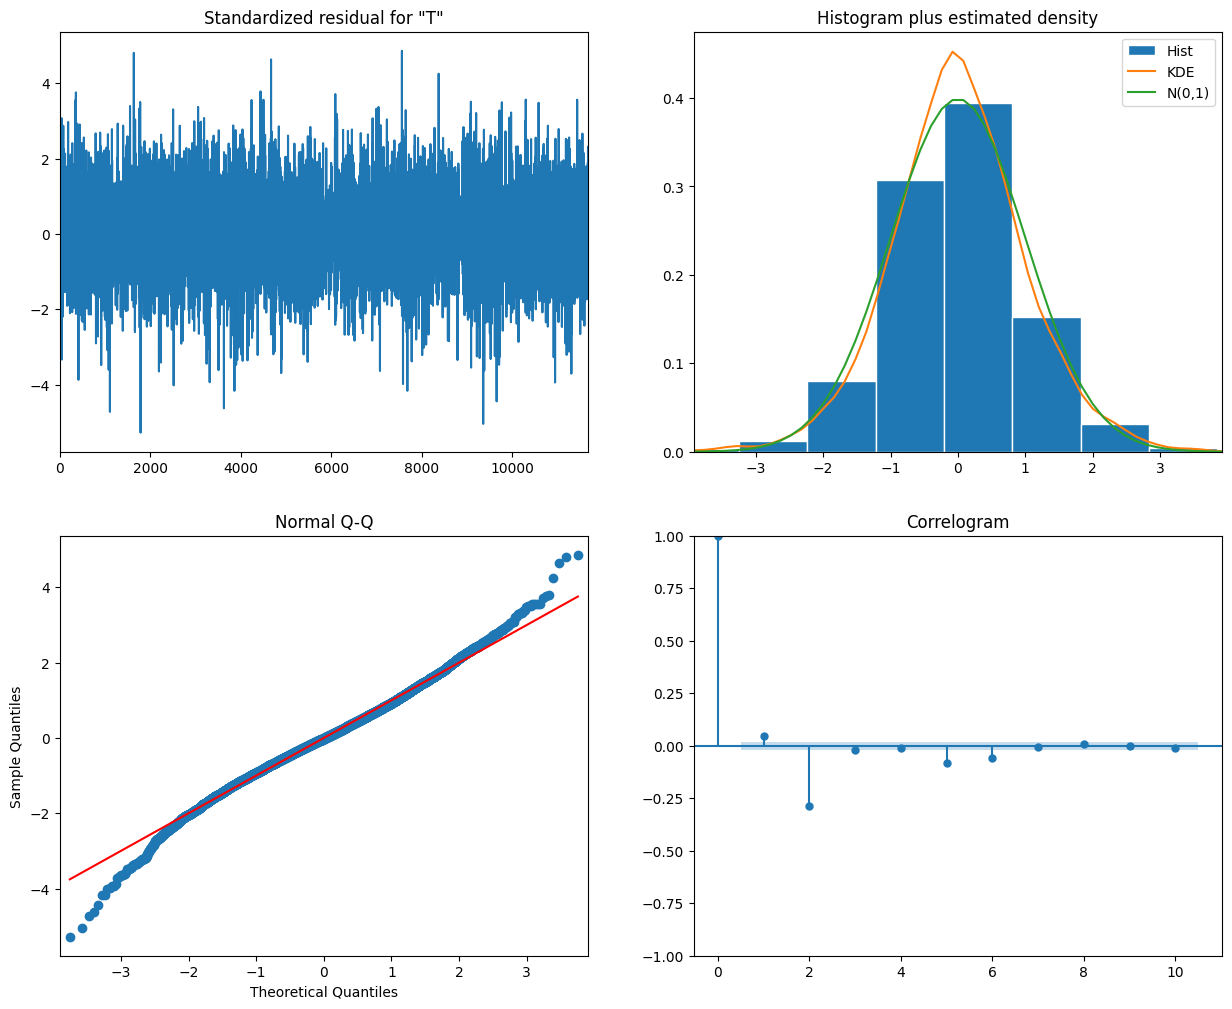

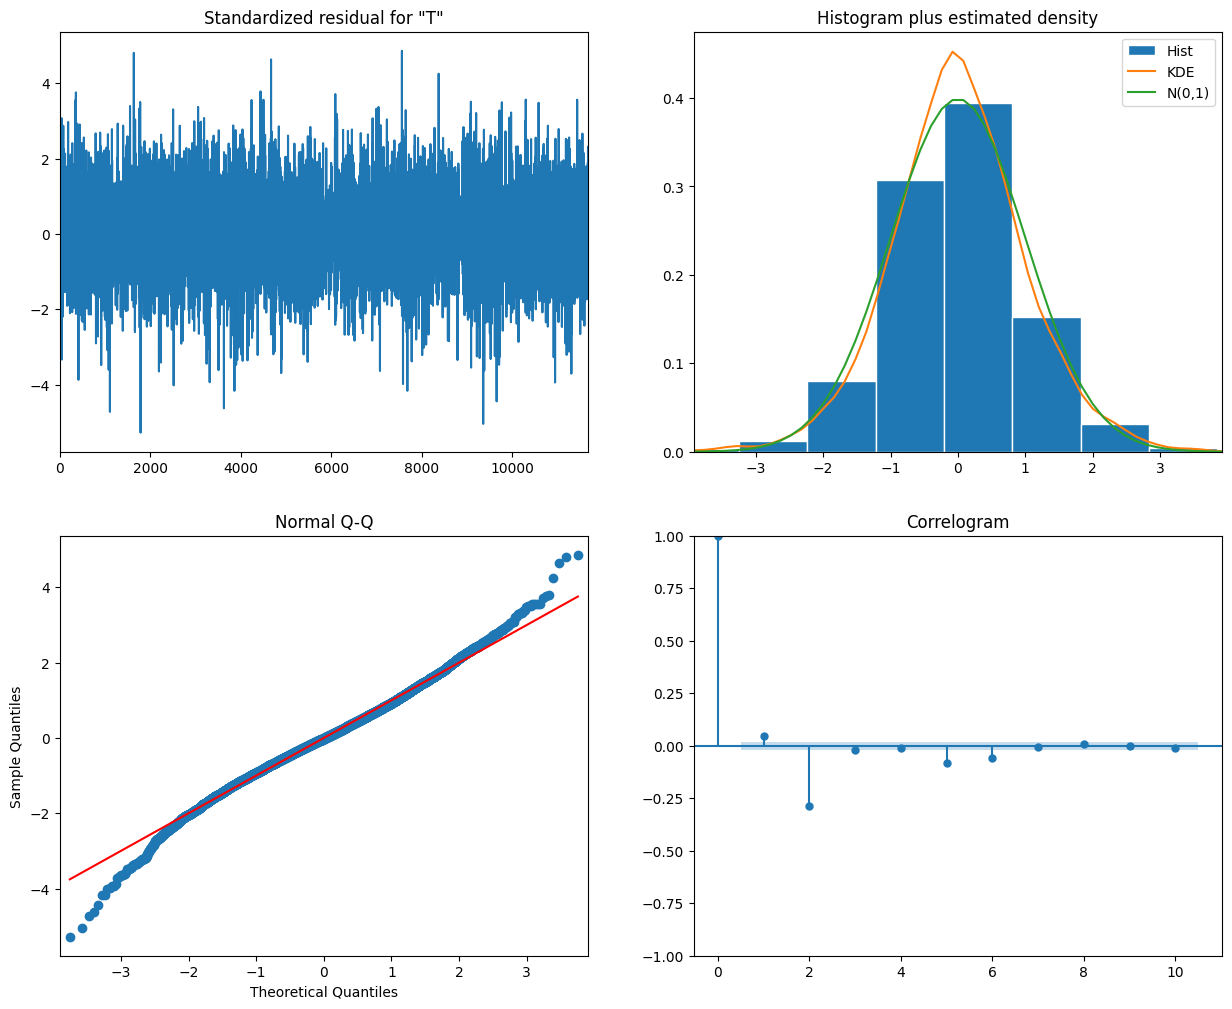

In [31]:
best_model.plot_diagnostics(figsize=(15,12))

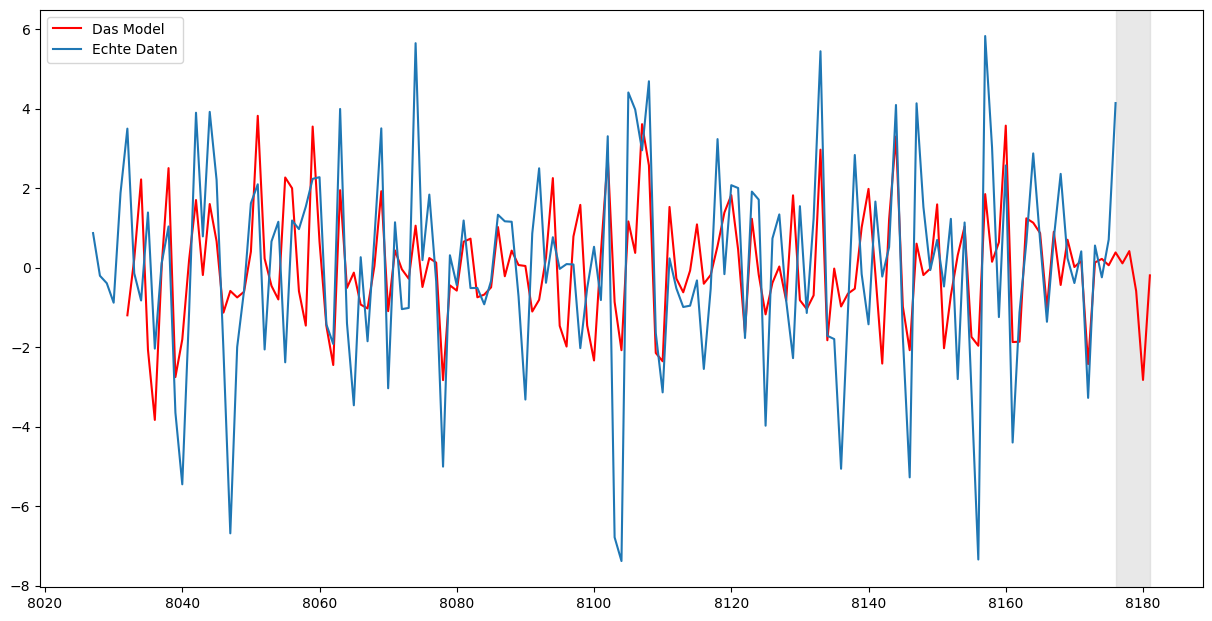

In [32]:
plot_data = train_data

plot_data['arima_model'] = best_model.fittedvalues
plot_data['arima_model'][:4+1] = np.NaN

forecast = best_model.predict(start=plot_data.shape[0], end=plot_data.shape[0] + 4)
forecast = plot_data['arima_model']._append(forecast) # Notizen für mich_append benuten und nicht append (neue Version von Pandas)

plt.figure(figsize=(15, 7.5))
plt.plot(forecast[-150:], color='r', label='Das Model')
plt.axvspan(plot_data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
plt.plot(plot_data[in_str][-150:], label='Echte Daten')
plt.legend()

plt.show()

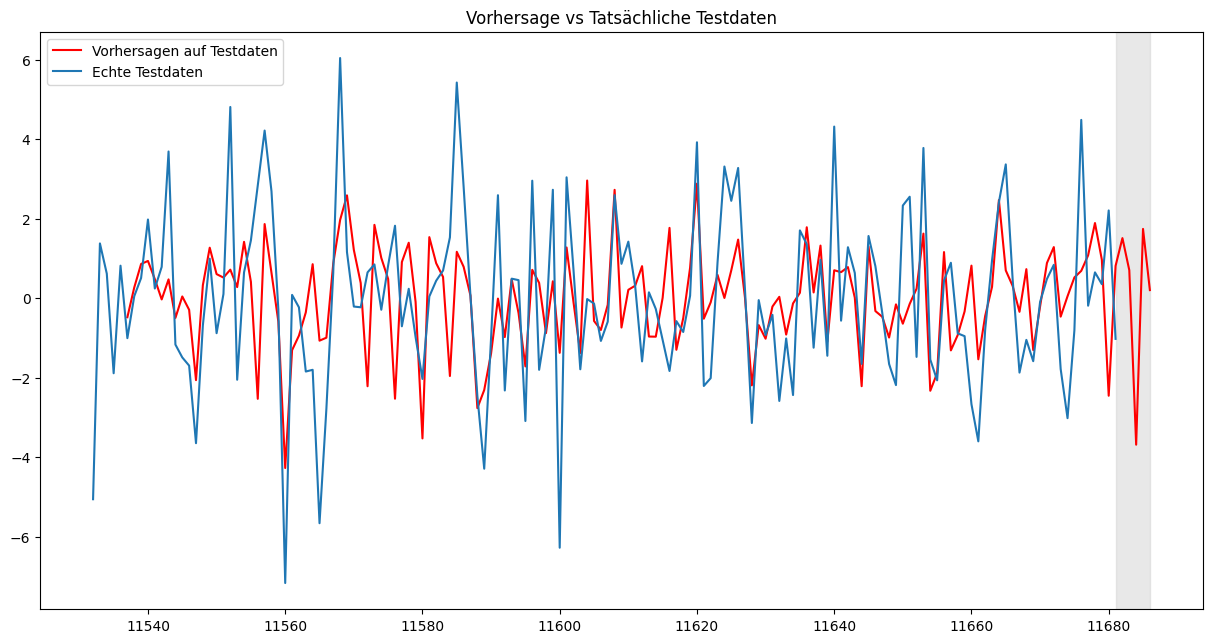

In [33]:
# TEST_DATA

test_forecast = best_model.predict(start=train_data.shape[0]+val_data.shape[0], end=train_data.shape[0]+val_data.shape[0] + test_data.shape[0]+4, exog=test_data[exog_str][-6:-1])

# Visualisierung der Vorhersagen für die Testdaten
plt.figure(figsize=(15, 7.5))
plt.plot(test_forecast[-150:], color='r', label='Vorhersagen auf Testdaten')
plt.axvspan(test_data.index[-1], test_forecast.index[-1], alpha=0.5, color='lightgrey')
plt.plot(test_data[in_str][-150:], label='Echte Testdaten')

plt.legend()
plt.title('Vorhersage vs Tatsächliche Testdaten')
plt.show() 

In [34]:
from sklearn.metrics import mean_absolute_error

# Berechnung des MAE
mae = mean_absolute_error(test_data[in_str], test_forecast[:-5])
mae

1.4859258029809457

In [35]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(test_data[in_str], test_forecast[:-5])
mse

3.734848120058761

In [36]:
def smape_loss(y_pred, target):
    loss = 2 * (y_pred - target).abs() / (y_pred.abs() + target.abs() + 1e-8)
    return loss.mean()
smape = smape_loss(test_data[in_str], test_forecast[:-5])
smape

1.207010727737814